# JADE and SLURM
## 

### Eric Kerfoot, King's College London, eric.kerfoot@kcl.ac.uk
### MONAI Developers, https://monai.io

* JADE is a multi-node system using SLURM to submit jobs
* Login nodes are the entry points for the system, all work should be done in jobs
* Different environment in an interactive or batch job, need to use environment efficiently
* For MONAI: how to construct environment and load data efficiently

* We'll cover here setting up an environment to run MONAI training jobs using Anaconda and Apptainer (Singularity)
* JADE does provide Docker containers with a number of libraries such as Pytorch, but we'll focus on making our own to ensure the right libraries are present.
* First thing when logging into JADE is get Miniconda installed:
```sh
[exk44-exk01@dgk328 ~]$ wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
...
2024-06-09 16:09:08 (119 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [143808873/143808873]
[exk44-exk01@dgk328 ~]$ bash Miniconda3-latest-Linux-x86_64.sh -b -u -p ~/miniconda3
```

* You can install Miniconda now in the login node, however setting up environments will be slow due to the file system
* Can't use an interactive job since the compute nodes do not have network access
* Next setup a MONAI environment **(NB: DON't USE NUMPY2)**:
```bash
[exk44-exk01@dgk227 ~]$ ./miniconda3/bin/conda create -n monai python\<3.12
[exk44-exk01@dgk227 ~]$ ./miniconda3/envs/monai/bin/pip install numpy\<2 monai[nibabel,pillow,ignite,fire]
...
```

* This will take a long time again, trying to import MONAI will take even longer:
```bash
[exk44-exk01@dgk227 ~]$ ./miniconda3/envs/monai/bin/python -c 'import monai;monai.config.print_config()'
...
```


Once this is done you can start an interactive job to run the environment:
```bash
[exk44-exk01@dgk328 ~]$ srun -p devel -c 8 --gres=gpu:1 --pty /bin/bash
bash-4.4$ ./miniconda3/envs/monai/bin/python
Python 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> import monai
>>> unet=monai.networks.nets.UNet(2,1,1,[2,4],[2]).to("cuda:0")
```

A number of things here to consider:
* Install Miniconda and creating an environment is very slow due to the file system
* Bash hooks are not used since they will be very slow when logging in
  * `eval "$(~/miniconda3/bin/conda shell.bash hook)"` to get it anyway
* Running Python within a job will be faster once everything is installed
* Remember to use `devel` queue in the interactive job and choose more than 1 CPU (`-c 8`)
* Data loading will be slow so we'll want to use the scratch drive when we can

### SLURM

* Used to schedule and manage jobs
* Shell scripts are submitted to run jobs
* Training with MONAI is a simple invocation of Python with a script
* Using Miniconda without initialising shell hooks

Simple program to demonstrate using Miniconda this way:

```bash
#! /bin/bash
#SBATCH --nodes=1
#SBATCH -J monai_test
#SBATCH -c 2
#SBATCH --gres=gpu:1
#SBATCH --time=0:10:00
#SBATCH -p devel

$HOME/miniconda3/envs/monai/bin/python -c 'import monai;monai.config.print_config()'
```

```bash
[exk44-exk01@dgk227 ~]$ sbatch monai_test.sh
Submitted batch job 653304
[exk44-exk01@dgk227 ~]$ sacct
JobID           JobName  Partition    Account  AllocCPUS      State ExitCode 
------------ ---------- ---------- ---------- ---------- ---------- -------- 
653304       monai_test      devel      exk01          2    RUNNING      0:0 
653304.batch      batch                 exk01          2    RUNNING      0:0 
[exk44-exk01@dgk227 ~]$ head slurm-653304.out 
MONAI version: 1.3.1
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /jmain02/home/J2AD019/exk01/<username>/miniconda3/envs/monai/lib/python3.11/site-packages/monai/__init__.py
```

* With a more complex example we can discuss data loading
* This is derived from the MONAI 101 Tutorial here: https://github.com/Project-MONAI/tutorials/blob/main/2d_classification/monai_101.ipynb
* Download the MedNIST dataset in the login node: 

  `wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz`
  
* The following will go into `monai_101.py`

* Start with imports:

```python
import os
import torch
from monai.apps import MedNISTDataset
from monai.data import DataLoader
from monai.engines import SupervisedTrainer
from monai.inferers import SimpleInferer
from monai.networks import eval_mode
from monai.networks.nets import densenet121
import monai.transforms as mt
```

* A few definitions and the network:

```python
# assumes tarball is in this temp directory
root_dir = os.environ["TEMPSTORE"]

max_epochs = 25
device = torch.device("cuda:0")
net = densenet121(spatial_dims=2, in_channels=1, out_channels=6).to(device)
```

* Transforms and dataset:

```python
transform = mt.Compose([
    mt.LoadImaged(keys="image", image_only=True),
    mt.EnsureChannelFirstd(keys="image"),
    mt.ScaleIntensityd(keys="image"),
])

dataset = MedNISTDataset(root_dir=root_dir,transform=transform,
                         section="training", progress=False)

train_dl = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=4)
```

* Trainer object and run:

```python
trainer = SupervisedTrainer(
    device=device,
    max_epochs=max_epochs,
    train_data_loader=train_dl,
    network=net,
    optimizer=torch.optim.Adam(net.parameters(), lr=1e-5),
    loss_function=torch.nn.CrossEntropyLoss()
)
trainer.run()
torch.jit.script(net).save("mednist.ts")
```

* Evaluate results:

```python
class_names = ("AbdomenCT", "BreastMRI", "CXR", "ChestCT", "Hand", "HeadCT")
testdata = MedNISTDataset(root_dir=root_dir, transform=transform, 
    section="test", download=False, progress=False, runtime_cache=True)

max_items_to_print = 10
eval_dl = DataLoader(testdata, batch_size=1, num_workers=0)
```

```python
with eval_mode(net):
    for _, item in zip(range(max_items_to_print),eval_dl):
        result = net(item["image"].to(device))
        prob = result.detach().to("cpu")[0]
        pred = class_names[prob.argmax()]
        gt = item["class_name"][0]
        print(f"Prediction: {pred}. Ground-truth: {gt}")
```

* The following into `monai_101.sh`:

```bash
#! /bin/bash
#SBATCH --nodes=1
#SBATCH -J monai_101
#SBATCH -c 4
#SBATCH --gres=gpu:1
#SBATCH --time=1:00:00
#SBATCH -p small
```
```bash
cd $HOME
export TEMPSTORE="/raid/local_scratch/$USER/$SLURM_JOBID"
cp MedNIST.tar.gz "$TEMPSTORE"

$HOME/miniconda3/envs/monai/bin/python monai_101.py
```

* Submit with `sbatch monai_101.sh`
* Classifier will take a bit of time to train, but much faster by moving the dataset into the scratch space
* This file system is available in jobs only and isn't expected to persist between jobs
* Moving MedNIST over was easy being so small, larger datasets would be difficult so consider preprocessing somehow to reduce space
* Training is ootherwise straight forward
* Note also name of queue (`small`), number of CPUs and GPUs, name, and runtime

### Apptainer

* An alternative is to build an Apptainer (Singularity) environment
* These can be created directly from the MONAI Docker image:

```bash
$ apptainer build monai.sif docker://projectmonai/monai:1.3.1
```

* For JADE users the advantage is to make the image locally then copy into your home and avoid the file system
* Cannot be created on the login nodes nor in jobs, so make on your machine and copy (yes it's ~8GiB I'm sorry)

```bash
#! /bin/bash
#SBATCH --nodes=1
#SBATCH -J monai_101_app
#SBATCH -c 4
#SBATCH --gres=gpu:1
#SBATCH --time=1:00:00
#SBATCH -p small

module load apptainer
```
```bash
cd $HOME
export TEMPSTORE="/raid/local_scratch/$USER/$SLURM_JOBID"
cp MedNIST.tar.gz "$TEMPSTORE"

apptainer run --nv \
  --bind $TEMPSTORE:/local_scratch \
  --env TEMPSTORE=/local_scratch \
  monai.sif python monai_101.py
```

* This `monai_101_app.sh` script looks very similar to previous one
* Difference is creating the Apptainer container and running the script in it
* MONAI image will include everything you need to run
* Need to mount the temp directory as `/local_scratch` and set the `TEMPSTORE` variable
* Key argument is **--nv** for enabling Nvidia support and so GPU access

### Bundles

*  MONAI architecture for packaging network weights with definitions, script files, metadata explaining purpose and use of network
* Defined as a directory structure with a metadata JSON file, JSON/YAML scripts declaring objects to constitute scripts for training, inference etc, documentation files, other scripts, and code
* Used in conjunction with the MONAI model zoo, MONAI Deploy, etc.
* Very useful for distributing your own model as well as training and experiment management
* Tutorials here: https://github.com/Project-MONAI/tutorials/tree/main/bundle

### Example Bundle Usage
* Example is MedNIST GAN model here: https://github.com/Project-MONAI/model-zoo/tree/dev/models/mednist_gan
* Implements the same code as here: https://github.com/Project-MONAI/tutorials/blob/main/modules/engines/gan_training.py
* Generates hand images from the MedNIST training set:

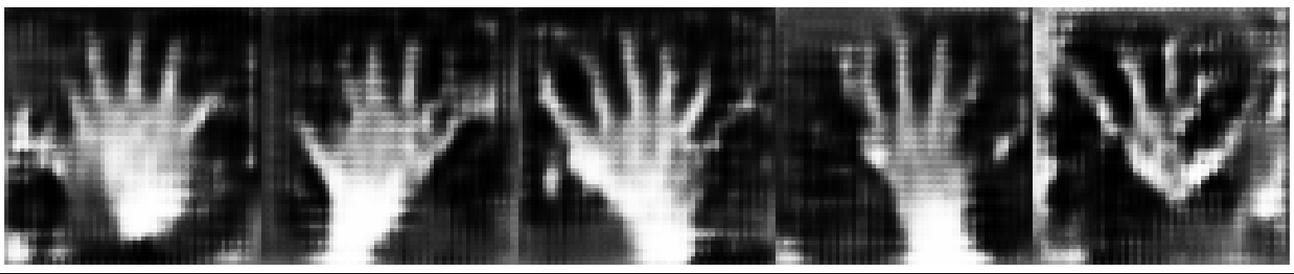

Download a simple bundle from the model zoo:

```bash
$ wget https://github.com/Project-MONAI/model-zoo/releases/download/hosting_storage_v1/mednist_gan_v0.4.2.zip
$ unzip mednist_gan_v0.4.2.zip
$ ls -l mednist_gan
total 28
drwxr-xr-x 2 exk44-exk01 exk01  4096 Jun 13 16:05 configs
drwxr-xr-x 2 exk44-exk01 exk01  4096 Jun 13 16:05 docs
-rw-r--r-- 1 exk44-exk01 exk01 11357 May 30  2022 LICENSE
drwxr-xr-x 2 exk44-exk01 exk01  4096 Jun 13 16:05 models
drwxr-xr-x 2 exk44-exk01 exk01  4096 Jun 13 16:05 scripts
```

Bundle structure:
```sh
configs
 ├── inference.json    <- inference script
 ├── logging.conf      <- logging settings
 ├── metadata.json     <- metadata
 └── train.json        <- train script
docs
 ├── data_license.txt  <- MedNIST license 
 └── README.md         <- bundle description
```
```
models              
 └── model.pt          <- saved model weights
scripts
 ├── __init__.py       <- empty
 └── losses.py         <- extra definitions
```

* MONAI provides programs for running bundles like command line scripts
* Designated JSON (or YAML) scripts will be interpreted and run
* MONAI users are encouraged to develop new models as bundles from the start with training/inference scripts rather than developing a model and packaging as a bundle afterwards

* Bundle JSON/YAML config scripts are in the `configs` directory
* Saved weights as Torch or Torchscript files stored in `models`
* `scripts` contains custom Python code which can be imported in configs
* `docs` contains all other information and extra content

* The `mednist_gan.sh` script is very similar to previous one:

```bash
#! /bin/bash
#SBATCH --nodes=1
#SBATCH -J mednist_gan
#SBATCH -c 12
#SBATCH --gres=gpu:1
#SBATCH --time=1:00:00
#SBATCH -p small
```

* A few changes for loading only the hand images:

```bash
export TEMPSTORE="/raid/local_scratch/$USER/$SLURM_JOBID"
cd "$TEMPSTORE"
tar xzf $HOME/MedNIST.tar.gz
cd $HOME

DATASETDIR=$TEMPSTORE/MedNIST/Hand
CKPT=none
BUNDLE="$HOME/mednist_gan"
export PYTHONPATH="$BUNDLE"
```

* Finally run the bundle:

```bash
$HOME/miniconda3/envs/monai/bin/python \
    -m monai.bundle run training \
    --meta_file "$BUNDLE/configs/metadata.json" \
    --config_file "$BUNDLE/configs/train.json" \
    --bundle_root "$BUNDLE" \
    --dataset_dir "$DATASETDIR" \
    --trainer::max_epochs 5 \
    --ckpt_path "$CKPT"
```

* Or with Apptainer:

```bash
apptainer run --nv \
    --bind $DATASETDIR:/data \
    monai.sif python -m monai.bundle run training \
    --meta_file "$BUNDLE/configs/metadata.json" \
    --config_file "$BUNDLE/configs/train.json" \
    --bundle_root "$BUNDLE" \
    --dataset_dir /data \
    --trainer::max_epochs 5 \
    --ckpt_path "$CKPT"
```

* Bundles use JSON/YAML files which define "programs" as series of object instantiations
* Configuration values and hyperparameters can also be described, eg. `dataset_dir`
* Constructor arguments can also be changed on the command line, eg. `trainer::max_epochs`
* Provides structure for defining programs and workflows beyond what raw code does
* Doing parameter sweeps or configuring through these script files is simplified through this interface

### JADE Best Practices
* Use the scratch drive. Reading from the root file system is slower.
* Avoid VSCode through ssh. It constantly checks the file system for changes.
* Avoid leaving servers running like tensorboard and wandb. These affect the filesystem as well.
* Don't run anything substantial on login nodes, eg. preprocessing. Create devel interactive jobs.
* Use current versions of Anaconda/Miniconda. Newer ones seem faster.
* Avoid large numbers of files. Since files take an essentially constant access time on top of the reading time, large numbers of small files are going to be slower than smaller numbers of large files.

### Next: MONAI Optimisations